In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mutils import DataHandler

Loaded BKO_E2_D4_05_Sandia.pkl
Total Sections: 1
index 0 for first section
J2 tempo for the current section: 91.98 BPM


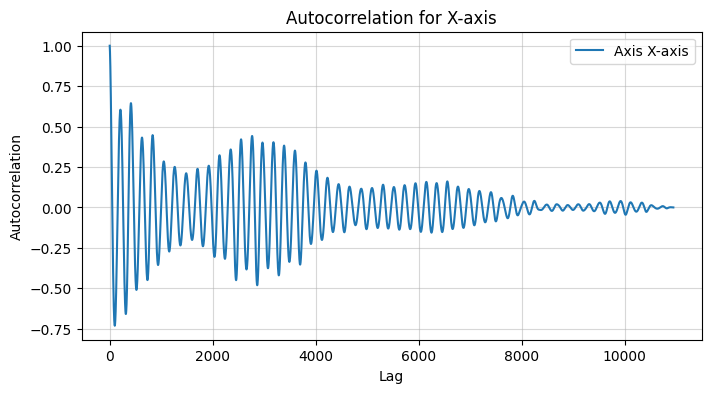

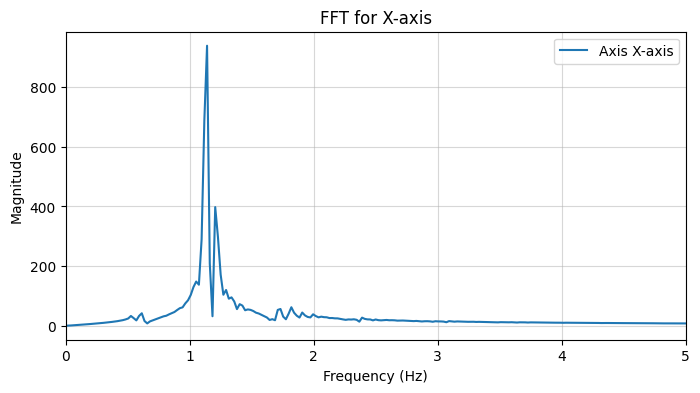

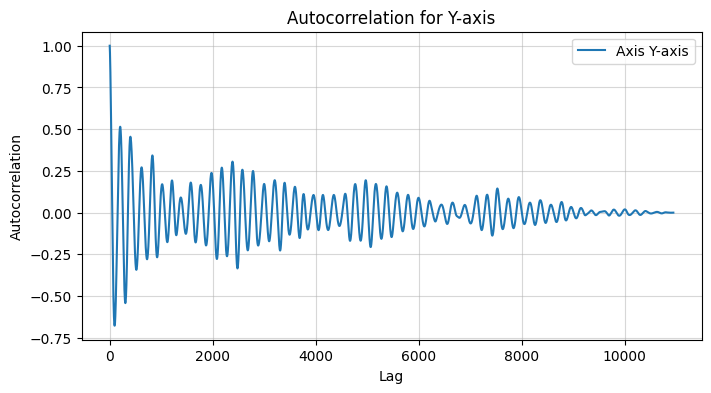

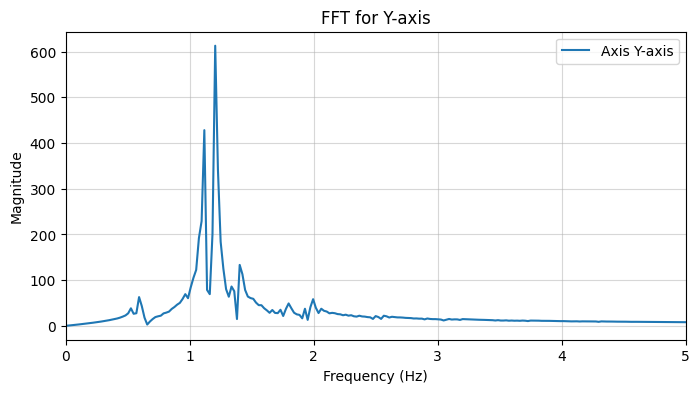

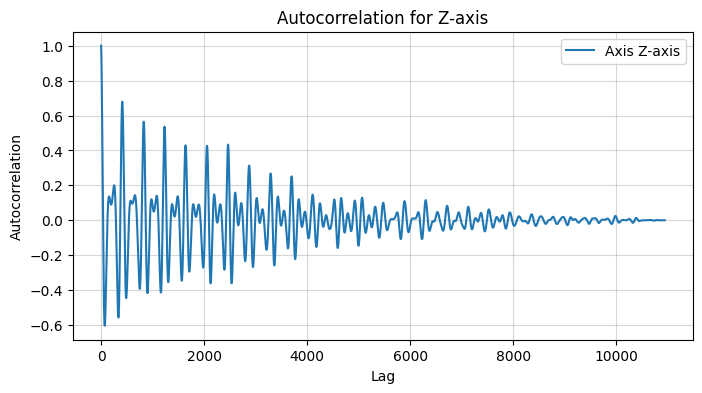

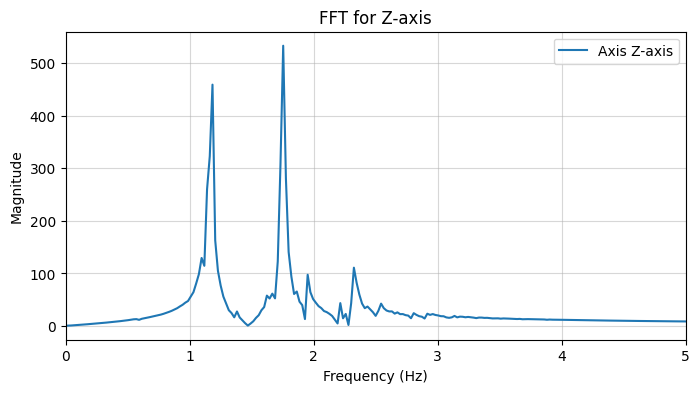

In [2]:

# SEGMENT_HEAD  SEGMENT_PELVIS   SEGMENT_T8  SEGMENT_LEFT_HAND  SEGMENT_LEFT_FOOT
pkl_filelist = os.listdir(f"./Dataset_V2")
data_handler = DataHandler()

# for filename in pkl_filelist:

filename = pkl_filelist[2]    
piece_name = os.path.basename(filename).split("_Dancers")[0]
try:
    motion_data, drum_onsets, start_f, end_f, start_t, end_t, cycle_onsets, beat_ref, bpm = data_handler.load_and_process_data(filename, mode = 'gr', drum = 'J2', section_idx=0)
except ValueError as e:
    # Handle the error and continue
    print(f"Error encountered for: {e}")
    # continue


mocap_fps = 240
sensorA_velocity = motion_data['velocity']["SEGMENT_LEFT_FOOT"]         # [start_f:end_f]
sensorA_velocity_norm = data_handler.z_score_normalize(sensorA_velocity)
sensorA_velocity = data_handler.detrend_signal_array(sensorA_velocity_norm, cutoff= 0.8)

sensor_vel_axes = data_handler.smooth_velocity(sensorA_velocity, abs='yes') # size (n, 3)
# sensor_vel_axes[sensor_vel_axes<0] = 0

novelty_length = len(sensorA_velocity)
time_axis = np.arange(novelty_length)/mocap_fps

ax_label = {
    0: "X-axis",
    1: "Y-axis",
    2: "Z-axis",
}

for ax in range(3):
# ax =2
    sensorA_vel = sensorA_velocity[start_f:end_f,ax]        #.reshape(-1,1)
    # plt.figure(figsize=(15, 5))
    # plt.plot(sensorA_vel[start_f:end_f])
    # plt.show()
    
    # autocorrelation 1
    autocorr1 = np.correlate(sensorA_vel, sensorA_vel, mode='full')  
    mid_point1 = len(sensorA_vel) - 1 
    autocorr1 = autocorr1[mid_point1:]  
    autocorr1 = autocorr1 / autocorr1[0]  # Normalize
    
    # autocorrelation 2
    autocorr2 = np.correlate(autocorr1, autocorr1, mode='full')  
    mid_point2 = len(autocorr1) - 1  # Zero lag index
    autocorr2 = autocorr2[mid_point2:]  # positive lags
    autocorr2 = autocorr2 / autocorr2[0]  # Normalize

    autocorr = autocorr2
    # FFT
    fft_result = np.fft.fft(autocorr)
    fft_magnitude = np.abs(fft_result)  
    frequencies = np.fft.fftfreq(len(autocorr), d=1/mocap_fps)
     
    positive_freqs = frequencies[frequencies >= 0]
    positive_magnitude = fft_magnitude[frequencies >= 0]
    
    # Positive lags for x axis
    lags_x_axis = np.arange(0, len(autocorr))  # Lag indices for positive lags

    # Plot autocorrelation
    plt.figure(figsize=(8, 4))
    plt.plot(lags_x_axis, autocorr, label=f'Axis {ax_label[ax]}')
    plt.title(f'Autocorrelation for {ax_label[ax]}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()
    
    # Plot FFT
    plt.figure(figsize=(8, 4))
    plt.plot(positive_freqs, positive_magnitude, label=f'Axis {ax_label[ax]}')
    plt.title(f'FFT for {ax_label[ax]}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(alpha=0.5)
    plt.xlim(0,5)
    plt.legend()
    plt.show()
